In [20]:
import os
import torch.nn as nn
import argparse
import deepcore.nets as nets
import deepcore.datasets as datasets
import deepcore.methods as methods
import torch
from torchvision import transforms
from utils import *
from datetime import datetime
from time import sleep
import numpy as np

# custom
from ptflops import get_model_complexity_info

# ImageNet selected Images

In [37]:
import easydict
 
args = easydict.EasyDict({
        # Setup
        "dataset": 'ImageNet',
        "core_resolution": 224,
        "resolution": 224,
        "core_model": 'ResNet18',
        "model":"ResNet18",
        "fraction": 0.05,
        "num_exp":1,
        "seed": 0,
        "data_path":'../data',
        "gpu":[1],
        "workers": 10,
        "print_freq":300,
        # Optimization
        "epochs":200,
        "batch_size": 128,
        "optimizer": 'SGD',
        "lr":0.1,
        "min_lr": 1e-4,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "nesterov": True,
        "scheduler": "CosineAnnealingLR",
        "selection_optimizer": "SGD",
        "selection_batch": 128,
        "selection_momentum": 0.9,
        "selection_weight_decay": 5e-4,
        "selection_nesterov": True,
        "selection_lr": 0.1,
        "selection_test_interval": 1,
        "selection_test_fraction": 1,
        # Coreset
        "selection": "Uncertainty", #kCenterGreedy Uncertainty
        "selection_epochs": 10,
        "balance": True,
        "uncertainty": 'Margin',
        "submodular": "GraphCut",
        "submodular_greedy": "LazyGreedy",
        "resume": 10
})
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])  

args.resolution = 224
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test = datasets.__dict__[args.dataset](args)

# imgnet224, Uniform Selection Examples

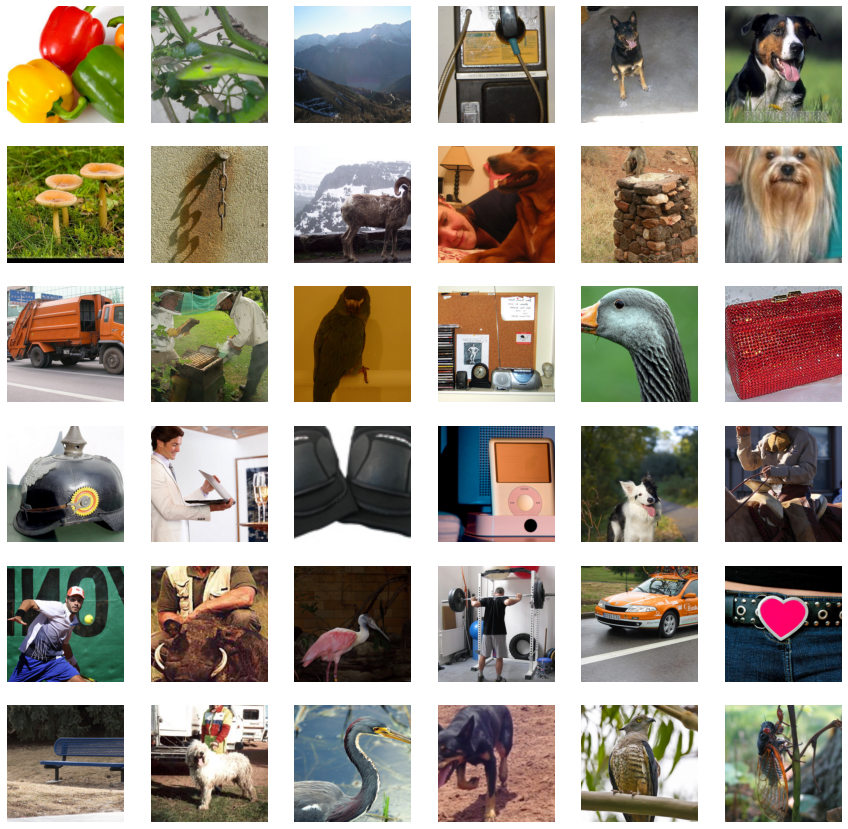

In [39]:
fig = plt.figure(figsize=(15, 15))
rows = 6
cols = 6
rand_idx = np.random.choice(len(dst_train), rows*cols, replace=False)
for i in range(rows): #Indexs
    for j in range(cols): #Labels
        idx = rand_idx[i*rows+j]
        img = to_pil_image(unorm(dst_train[idx][0]))
        idx = (rows*i)+j+1
        fig.add_subplot(rows, cols, idx)
        plt.imshow(img)
        plt.axis('off')
plt.show()

# imgnet224, Margin Selection Examples

In [40]:
folder_path = 'result/imgnet_224/'
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(files[0])

groups = ['Uniform', 'kCenterGreedy', 'Uncertainty', 'Forgetting', 'GraNd', 'GradMatch', 'Submodular']
fr_dict = {'0.01':0, '0.05':1, '0.1':2, '0.2':3, '0.4':4}

target_g = 'Uncertainty'
target_fr = '0.05'
target_exp = 0

for i, f in enumerate(files):
    group = f.split('_')[2]
    fr = f.split('_')[6].split('fr')[1]
    exp = int(f.split('_')[3].split('exp')[1])

    if group == target_g and fr == target_fr and exp == target_exp:
        checkpoint_margin = torch.load(folder_path+f)

checkpoint_margin.keys()

ImageNet_ResNet18_GradMatch_exp0_se10_2022-07-20 01:57:15.450892_fr0.05_31.188000.ckpt


dict_keys(['exp', 'epoch', 'best_acc1', 'rec', 'subset', 'elapsed_time', 'sel_args'])

In [41]:
indices_margin = checkpoint_margin['subset']['indices']
print(indices_margin)

[   1194     836     723 ... 1280529 1280496 1279891]


In [42]:
folder_path = 'result/imgnet_32/'
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(files[0])

groups = ['Uniform', 'kCenterGreedy', 'Uncertainty', 'Forgetting', 'GraNd', 'GradMatch', 'Submodular']
fr_dict = {'0.01':0, '0.05':1, '0.1':2, '0.2':3, '0.4':4}

target_g = 'Uncertainty'
target_fr = '0.05'
target_exp = 0

for i, f in enumerate(files):
    group = f.split('_')[2]
    fr = f.split('_')[7].split('fr')[1]
    exp = int(f.split('_')[3].split('exp')[1])

    if group == target_g and fr == target_fr and exp == target_exp:
        checkpoint_margin = torch.load(folder_path+f)

checkpoint_margin.keys()

ImageNet_ResNet18_Uncertainty_exp0_se10_2022-07-19 14:18:30.854523_archResNet18_fr0.05_40.672000.ckpt


dict_keys(['exp', 'epoch', 'warmup_acc', 'best_acc1', 'rec', 'subset', 'elapsed_time', 'sel_args'])

In [24]:
indices_margin_32 = checkpoint_margin['subset']['indices']
print(indices_margin_32)

[    201      41     456 ... 1279891 1281079 1280291]


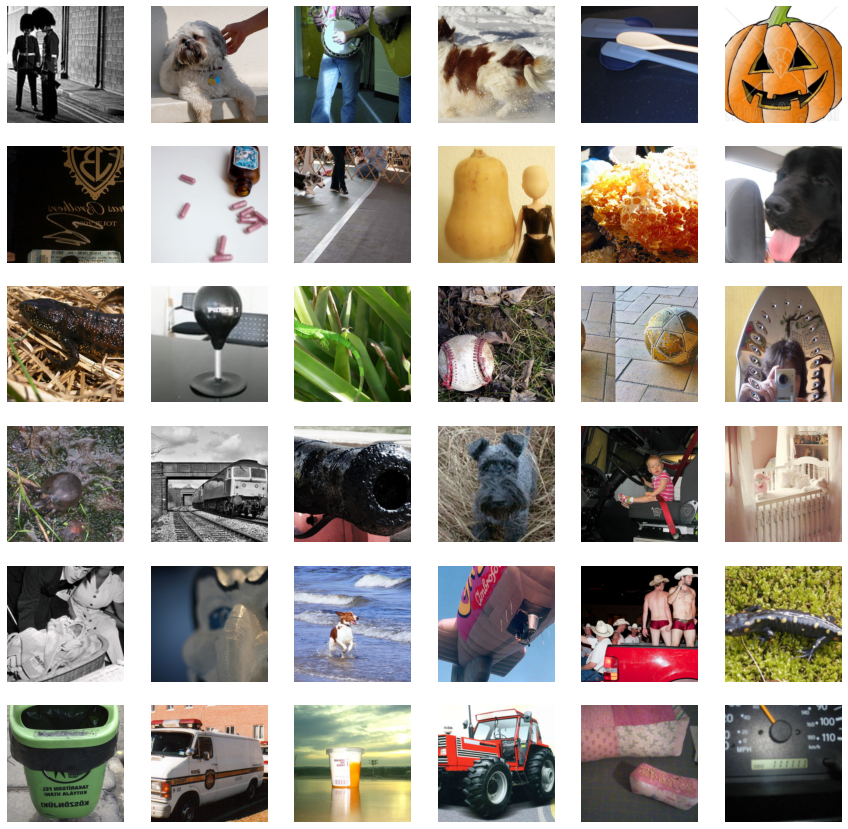

In [32]:
fig = plt.figure(figsize=(15, 15))
rows = 6
cols = 6
rand_idx = np.random.choice(indices_margin, rows*cols, replace=False)
for i in range(rows): #Indexs
    for j in range(cols): #Labels
        idx = rand_idx[i*rows+j]
        img = to_pil_image(unorm(dst_train[idx][0]))
        idx = (rows*i)+j+1
        fig.add_subplot(rows, cols, idx)
        plt.imshow(img)
        plt.axis('off')
plt.show()

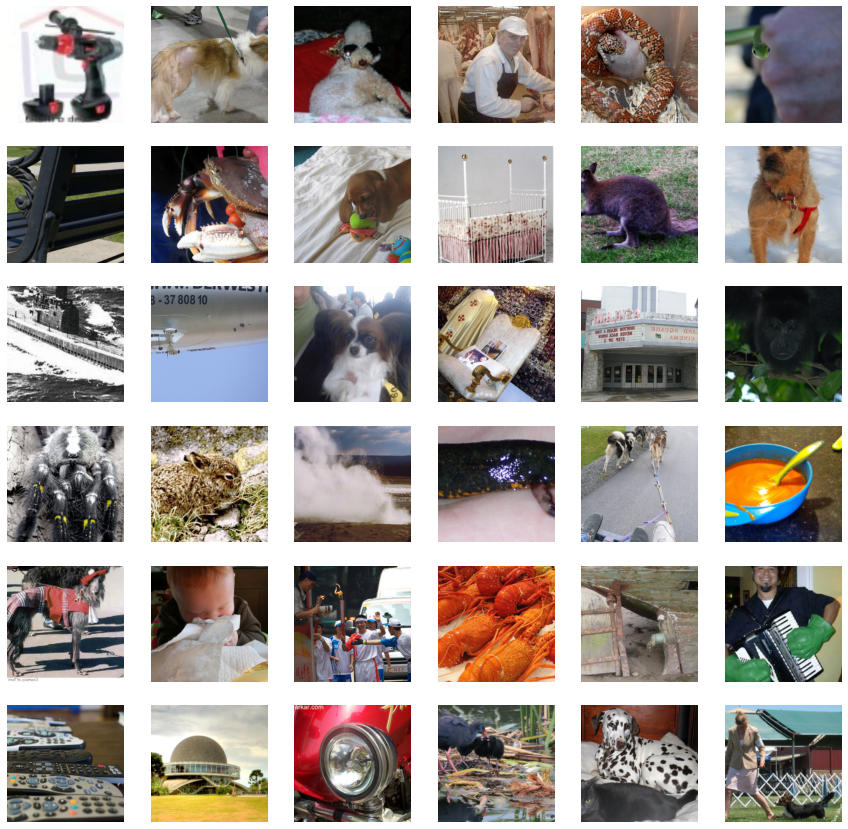

In [33]:
fig = plt.figure(figsize=(15, 15))
rows = 6
cols = 6
rand_idx = np.random.choice(indices_margin_32, rows*cols, replace=False)
for i in range(rows): #Indexs
    for j in range(cols): #Labels
        idx = rand_idx[i*rows+j]
        img = to_pil_image(unorm(dst_train[idx][0]))
        idx = (rows*i)+j+1
        fig.add_subplot(rows, cols, idx)
        plt.imshow(img)
        plt.axis('off')
plt.show()

# GradMatch

In [43]:
folder_path = 'result/imgnet_224/'
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(files[0])

groups = ['Uniform', 'kCenterGreedy', 'Uncertainty', 'Forgetting', 'GraNd', 'GradMatch', 'Submodular']
fr_dict = {'0.01':0, '0.05':1, '0.1':2, '0.2':3, '0.4':4}

target_g = 'GradMatch'
target_fr = '0.05'
target_exp = 0

for i, f in enumerate(files):
    group = f.split('_')[2]
    fr = f.split('_')[6].split('fr')[1]
    exp = int(f.split('_')[3].split('exp')[1])

    if group == target_g and fr == target_fr and exp == target_exp:
        checkpoint_GradMatch = torch.load(folder_path+f)

checkpoint_GradMatch.keys()

ImageNet_ResNet18_GradMatch_exp0_se10_2022-07-20 01:57:15.450892_fr0.05_31.188000.ckpt


dict_keys(['exp', 'epoch', 'best_acc1', 'rec', 'subset', 'elapsed_time', 'sel_args'])

In [35]:
indices_GradMatch = checkpoint_GradMatch['subset']['indices']
print(indices_GradMatch)

[      6      33      81 ... 1281162 1281163 1281164]


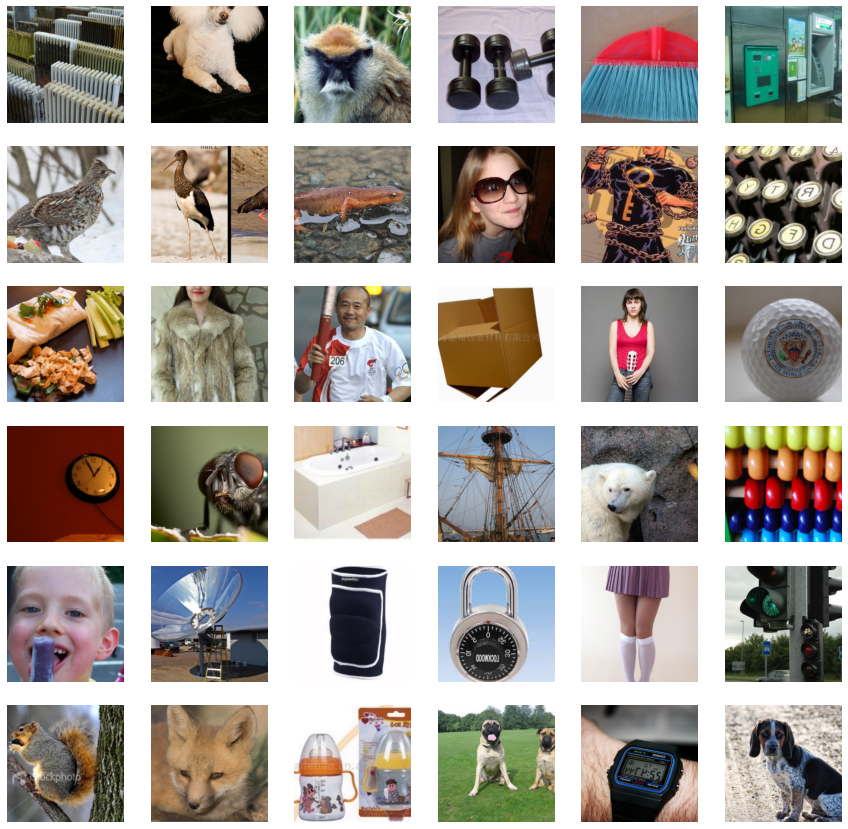

In [36]:
fig = plt.figure(figsize=(15, 15))
rows = 6
cols = 6
rand_idx = np.random.choice(indices_GradMatch, rows*cols, replace=False)
for i in range(rows): #Indexs
    for j in range(cols): #Labels
        idx = rand_idx[i*rows+j]
        img = to_pil_image(unorm(dst_train[idx][0]))
        idx = (rows*i)+j+1
        fig.add_subplot(rows, cols, idx)
        plt.imshow(img)
        plt.axis('off')
plt.show()

In [46]:
folder_path = 'result/imgnet_32/'
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(files[0])

groups = ['Uniform', 'kCenterGreedy', 'Uncertainty', 'Forgetting', 'GraNd', 'GradMatch', 'Submodular']
fr_dict = {'0.01':0, '0.05':1, '0.1':2, '0.2':3, '0.4':4}

target_g = 'GradMatch'
target_fr = '0.05'
target_exp = 0

for i, f in enumerate(files):
    group = f.split('_')[2]
    fr = f.split('_')[7].split('fr')[1]
    exp = int(f.split('_')[3].split('exp')[1])

    if group == target_g and fr == target_fr and exp == target_exp:
        checkpoint_GradMatch = torch.load(folder_path+f)

indices_GradMatch_32 = checkpoint_GradMatch['subset']['indices']
print(indices_GradMatch_32)

ImageNet_ResNet18_Uncertainty_exp0_se10_2022-07-19 14:18:30.854523_archResNet18_fr0.05_40.672000.ckpt
[      5      16      33 ... 1281162 1281163 1281164]


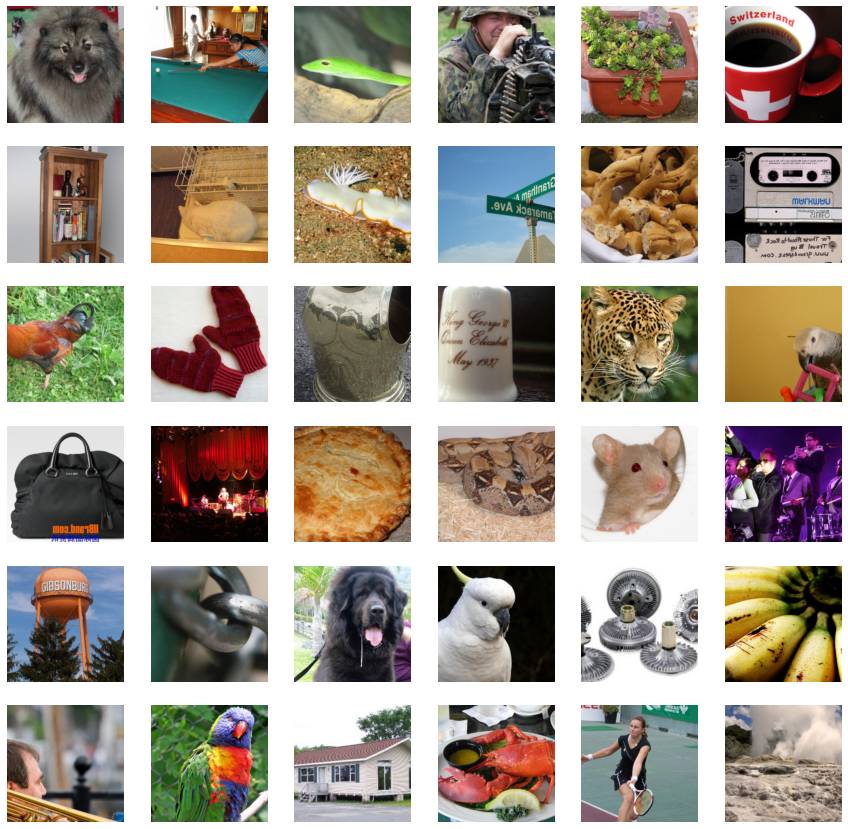

In [47]:
fig = plt.figure(figsize=(15, 15))
rows = 6
cols = 6
rand_idx = np.random.choice(indices_GradMatch_32, rows*cols, replace=False)
for i in range(rows): #Indexs
    for j in range(cols): #Labels
        idx = rand_idx[i*rows+j]
        img = to_pil_image(unorm(dst_train[idx][0]))
        idx = (rows*i)+j+1
        fig.add_subplot(rows, cols, idx)
        plt.imshow(img)
        plt.axis('off')
plt.show()

In [53]:
checkpoint_GradMatch['subset']['weights'][:100]

array([6.3040279e-05, 6.6255998e-05, 6.3572428e-05, 6.5098910e-05,
       6.2299623e-05, 6.6525012e-05, 6.7724679e-05, 6.5618704e-05,
       6.7030211e-05, 6.2209241e-05, 7.4485186e-05, 6.6802619e-05,
       6.8298454e-05, 6.1586150e-05, 6.3377818e-05, 6.1995430e-05,
       7.1173752e-05, 6.3538391e-05, 6.5960514e-05, 6.5998902e-05,
       6.2286046e-05, 6.1498264e-05, 6.2459731e-05, 6.2698491e-05,
       7.7871358e-05, 6.4807922e-05, 6.4333224e-05, 6.5467757e-05,
       6.1674778e-05, 6.2720617e-05, 6.3060972e-05, 6.4137552e-05,
       6.4127467e-05, 6.2798921e-05, 7.0512921e-05, 6.8990099e-05,
       6.3367559e-05, 6.5941400e-05, 7.4083051e-05, 8.4083549e-05,
       6.4293767e-05, 6.1434410e-05, 6.9648682e-05, 6.1366161e-05,
       6.2161067e-05, 6.2180188e-05, 6.7366091e-05, 6.3611769e-05,
       6.1894483e-05, 6.8670575e-05, 1.4627898e-04, 6.7363179e-04,
       1.8706030e-04, 4.1373496e-04, 6.3560263e-04, 5.2327244e-04,
       3.3934496e-04, 7.9126447e-05, 4.3121990e-04, 5.2979658e